<a href="https://colab.research.google.com/github/nayan-develper/Credit-Default-Risk-Prediction-Model/blob/main/research_p1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#!pip install is a magic command for Colab
!pip install transformers datasets accelerate scikit-learn
!pip install codecarbon # For measuring the "Green" impact
!pip install sentencepiece # Required for T5 tokenizer

In [4]:
!pip install tokenizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.0/41.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00


In [5]:
from datasets import load_dataset
import pandas as pd

# 1. Load Dataset from Hugging Face
print("Loading 'GonzaloA/fake_news' dataset...")
dataset = load_dataset("GonzaloA/fake_news")

# 2. Convert to Pandas for Cleaning
df = dataset['train'].to_pandas()

# 3. Cleaning Protocol (As per Research Plan)
# Drop 'Unnamed: 0' if it exists to prevent index-learning
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# Concatenate Title + Text for maximum context (standard baseline)
# We fill NaNs to prevent errors
df['content'] = df['title'].fillna('') + " " + df['text'].fillna('')

# 4. Filter for Speed (Optional: Use full dataset for final paper)
# For the Colab demo, we use 2,000 samples to run fast.
# Comment this out to run the full 40k dataset (takes ~2-3 hours).
df = df.sample(2000, random_state=42).reset_index(drop=True)

print(f"Data Loaded. Shape: {df.shape}")
print(df.head(2))

Loading 'GonzaloA/fake_news' dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/38.8M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/24353 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/8117 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8117 [00:00<?, ? examples/s]

Data Loaded. Shape: (2000, 4)
                                               title  \
0  TUCKER CARLSON EXPOSES REFUGEE CONTRACTOR Who ...   
1  Romania negotiating to buy U.S. rocket systems...   

                                                text  label  \
0  WORLD RELIEF received over $43 million dollars...      0   
1  WASHINGTON (Reuters) - The U.S. State Departme...      1   

                                             content  
0  TUCKER CARLSON EXPOSES REFUGEE CONTRACTOR Who ...  
1  Romania negotiating to buy U.S. rocket systems...  


In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm.auto import tqdm

# 1. Setup T5-Small (The Efficient Summarizer)
device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

def green_summarize(text):
    """
    Compresses text to < 64 tokens using Abstractive Summarization.
    Acts as a noise filter and dimensionality reducer.
    """
    input_text = "summarize: " + str(text)
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        max_length=512,
        truncation=True
    ).to(device)

    # Generate summary
    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=64,       # Compression Target
        min_length=10,
        length_penalty=2.0,
        num_beams=2,
        early_stopping=True
    )
    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)

# 2. Apply Optimization
print(f"Starting Input Optimization on {device}... (This creates your novel dataset)")
tqdm.pandas()
df['optimized_input'] = df['content'].progress_apply(green_summarize)

# Save this! This is your research artifact.
df.to_csv("green_optimized_dataset.csv", index=False)
print("Optimization Complete. Dataset saved.")

Starting Input Optimization on cuda... (This creates your novel dataset)


  0%|          | 0/2000 [00:00<?, ?it/s]

Optimization Complete. Dataset saved.


In [23]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from datasets import Dataset

# 1. Prepare Data for BERT
# We use the SUMMARIES (optimized_input) not the raw text
X = df['optimized_input'].tolist()
y = df['label'].tolist()

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize for DistilBERT
bert_model_name = "distilbert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

def tokenize_function(examples):
    return bert_tokenizer(examples['text'], padding="max_length", truncation=True, max_length=128)

# Convert back to HF Dataset for efficiency
train_dataset = Dataset.from_dict({"text": X_train, "label": y_train})
test_dataset = Dataset.from_dict({"text": X_test, "label": y_test})

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

# 2. Model Setup
model = AutoModelForSequenceClassification.from_pretrained(bert_model_name, num_labels=2)

# 3. Metrics Function
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='binary')
    return {'accuracy': acc, 'f1': f1}

# 4. Training Arguments (Hyperparameters from Research)
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,              # Standard for fine-tuning
    per_device_train_batch_size=16,  # 16 fits on Colab GPU easily
    per_device_eval_batch_size=64,
    warmup_steps=500,                # Prevents early divergence
    weight_decay=0.01,               # Regularization
    logging_dir='./logs',
    logging_steps=10,
    # Removed evaluation_strategy, save_strategy, and load_best_model_at_end to resolve Type/ValueErrors
)

# 5. Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)

# 6. Train
print("Starting Training of Green-Mingle Classifier...")
trainer.train()

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

Map:   0%|          | 0/400 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[codecarbon WARNING @ 14:56:34] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:56:34] [setup] RAM Tracking...
[codecarbon INFO @ 14:56:34] [setup] CPU Tracking...
[codecarbon WARNING @ 14:56:35] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:56:35] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist, and are readable, at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:56:35] CPU Model on constant consumption mode: Int

Starting Training of Green-Mingle Classifier...


Step,Training Loss
10,0.675500
20,0.679500
30,0.672600
40,0.671000
50,0.652000
60,0.644400
70,0.619100
80,0.577200
90,0.556400
100,0.497700


[codecarbon INFO @ 14:56:51] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:56:51] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:56:51] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 14:56:51] Energy consumed for all GPUs : 0.000256 kWh. Total GPU Power : 61.51110697480536 W
[codecarbon INFO @ 14:56:51] 0.000475 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 14:57:06] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:57:06] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:57:06] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 14:57:06] Energy consumed for all GPUs : 0.000537 kWh. Total GPU Power : 67.4316452212529 W
[codecarbon INFO @ 14:57:06] 0.000975 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 14:57:

TrainOutput(global_step=300, training_loss=0.42763533035914103, metrics={'train_runtime': 61.998, 'train_samples_per_second': 77.422, 'train_steps_per_second': 4.839, 'total_flos': 158960878387200.0, 'train_loss': 0.42763533035914103, 'epoch': 3.0})

In [24]:
# Evaluate the model

# Check if trainer is defined before attempting to use it
if 'trainer' in locals() and trainer is not None:
    results = trainer.evaluate()

    print("\n" + "="*40)
    print(" FINAL RESEARCH RESULTS ")
    print("="*40)
    print(f"Approach: Summarization (T5) + DistilBERT")
    print(f"Accuracy: {results['eval_accuracy']:.4f}")
    print(f"F1 Score: {results['eval_f1']:.4f}")
    print("="*40)

    # Save the model so you can use it later
    trainer.save_model("./final_green_model")
    # Ensure bert_tokenizer is also defined before saving it
    if 'bert_tokenizer' in globals():
        bert_tokenizer.save_pretrained("./final_green_model") # Explicitly save the tokenizer
    else:
        print("Warning: bert_tokenizer not found, cannot save tokenizer with the model.")
    print("Model and tokenizer saved to ./final_green_model")
else:
    print("Trainer object not found. Please re-run the Green-Mingle classifier training cell (8C0KcFE2J0RE) first to define 'trainer' and 'bert_tokenizer'.")
    print("Then, execute this cell again to perform evaluation and save the model.")


 FINAL RESEARCH RESULTS 
Approach: Summarization (T5) + DistilBERT
Accuracy: 0.8975
F1 Score: 0.9021
Model and tokenizer saved to ./final_green_model


In [25]:
import torch
import gc

# 1. Delete the old model from memory (we saved it to disk, so it's safe)
try:
    del model
    del trainer
except NameError:
    pass

# 2. Force garbage collection
gc.collect()

# 3. Clear GPU cache
torch.cuda.empty_cache()

print("GPU Memory Cleared. Ready for Phase 3.")

GPU Memory Cleared. Ready for Phase 3.


In [26]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import accuracy_score, f1_score
from datasets import load_dataset
import pandas as pd
import numpy as np

# 1. Load the same dataset (Raw Text this time, NO summarization)
print("Loading Raw Data for Baseline...")
dataset = load_dataset("GonzaloA/fake_news")
# We use a subset (2000 samples) to match Phase 2's demo speed
df_base = dataset['train'].to_pandas().sample(2000, random_state=42)
df_base = df_base.dropna()
# CRITICAL: Here we use the FULL RAW CONTENT, not the summary
df_base['content'] = df_base['title'].fillna('') + " " + df_base['text'].fillna('')

# 2. Tokenize for Standard BERT (Heavy Model)
print("Tokenizing Raw Data (This takes longer than summaries)...")
tokenizer_base = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_base(batch):
    # Note: max_length=512 is standard BERT limit (much larger than our Green 64)
    return tokenizer_base(batch['content'], padding="max_length", truncation=True, max_length=512)

# Convert to HF Dataset
from datasets import Dataset
base_ds = Dataset.from_pandas(df_base[['content', 'label']])
base_encoded = base_ds.map(tokenize_base, batched=True)
base_encoded = base_encoded.train_test_split(test_size=0.2)

# 3. Load Heavy Model
model_base = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# 4. Train Baseline
# We use fewer epochs (1) just for the demo, but in a real paper, you'd use 3.
training_args = TrainingArguments(
    output_dir="./results_base",
    num_train_epochs=1,
    per_device_train_batch_size=8, # Smaller batch size because BERT is heavy/fat
    # Removed evaluation_strategy and save_strategy to resolve TypeError
)

trainer_base = Trainer(
    model=model_base,
    args=training_args,
    train_dataset=base_encoded['train'],
    eval_dataset=base_encoded['test'],
    compute_metrics=lambda p: {"acc": accuracy_score(p.label_ids, np.argmax(p.predictions, axis=1))}
)

print("Starting Training of Heavy Baseline (Red AI)...")
trainer_base.train()
print("Baseline Training Complete.")

Loading Raw Data for Baseline...


Repo card metadata block was not found. Setting CardData to empty.


Tokenizing Raw Data (This takes longer than summaries)...


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[codecarbon WARNING @ 14:58:27] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 14:58:27] [setup] RAM Tracking...
[codecarbon INFO @ 14:58:27] [setup] CPU Tracking...
[codecarbon WARNING @ 14:58:28] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 14:58:28] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist, and are readable, at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 14:58:28] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 14:58:28] 

Starting Training of Heavy Baseline (Red AI)...


Step,Training Loss


[codecarbon INFO @ 14:58:45] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:58:45] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:58:45] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 14:58:45] Energy consumed for all GPUs : 0.000286 kWh. Total GPU Power : 68.43181926106563 W
[codecarbon INFO @ 14:58:45] 0.000504 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 14:59:00] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 14:59:00] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 14:59:00] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 14:59:00] Energy consumed for all GPUs : 0.000573 kWh. Total GPU Power : 69.13184614922616 W
[codecarbon INFO @ 14:59:00] 0.001011 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 14:59

Baseline Training Complete.


In [27]:
from codecarbon import EmissionsTracker
import time
import torch

# Helper function to measure performance
def benchmark_model(model, tokenizer, texts, name="Model"):
    print(f"\n🏁 Benchmarking {name}...")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)
    model.eval()

    # 1. Start Energy Tracker
    tracker = EmissionsTracker(project_name=name, measure_power_secs=1, output_dir="./", save_to_file=False)
    tracker.start()

    start_time = time.time()

    # 2. Run Inference Loop (Simulate reading 100 news articles)
    sample_texts = texts[:100]
    print(f"Processing {len(sample_texts)} articles...")

    for text in sample_texts:
        # Tokenize (Latency includes tokenization!)
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to(device)
        with torch.no_grad():
            _ = model(**inputs)

    end_time = time.time()

    # 3. Stop Tracker
    emissions = tracker.stop()
    duration = end_time - start_time

    return {
        "Model": name,
        "Total Time (s)": round(duration, 4),
        "Avg Latency (ms)": round((duration/len(sample_texts))*1000, 2),
        "CO2 Emissions (kg)": emissions
    }

# --- PREPARE THE RACERS ---

# 1. Load Data for both
# Baseline uses Raw Text
raw_texts = df_base['content'].tolist()
# Green uses Summaries (Load the file we saved in Phase 2)
df_green = pd.read_csv("green_optimized_dataset.csv")
green_texts = df_green['optimized_input'].astype(str).tolist()

# 2. Load Your Green Model (From Phase 2)
model_green = AutoModelForSequenceClassification.from_pretrained("final_green_model")
tokenizer_green = AutoTokenizer.from_pretrained("final_green_model")

# 3. RUN THE RACE
# Race the Heavy Model (Already loaded as model_base)
results_base = benchmark_model(model_base, tokenizer_base, raw_texts, name="Standard BERT (Red AI)")

# Race the Green Model
results_green = benchmark_model(model_green, tokenizer_green, green_texts, name="Green-Mingle (Ours)")

# 4. Show the Winner
print("\n" + "="*60)
print("🏆 FINAL RESULTS TABLE 🏆")
print("="*60)
results_df = pd.DataFrame([results_base, results_green])
print(results_df)

[codecarbon WARNING @ 15:01:37] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 15:01:38] [setup] RAM Tracking...
[codecarbon INFO @ 15:01:38] [setup] CPU Tracking...



🏁 Benchmarking Standard BERT (Red AI)...


[codecarbon WARNING @ 15:01:39] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:01:39] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist, and are readable, at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:01:39] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 15:01:39] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:01:39] [setup] GPU Tracking...
[codecarbon INFO @ 15:01:39] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 15:01:39] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 15:01:39] >>> Tracker's metadata:
[codecarbon INFO @ 15:01

Processing 100 articles...


[codecarbon INFO @ 15:01:40] Energy consumed for RAM : 0.000003 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:01:40] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 15:01:40] Energy consumed for All CPU : 0.000012 kWh
[codecarbon INFO @ 15:01:40] Energy consumed for all GPUs : 0.000018 kWh. Total GPU Power : 62.791549916230885 W
[codecarbon INFO @ 15:01:40] 0.000033 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:01:41] Energy consumed for RAM : 0.000006 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:01:41] Delta energy consumed for CPU with constant : 0.000012 kWh, power : 42.5 W
[codecarbon INFO @ 15:01:41] Energy consumed for All CPU : 0.000024 kWh
[codecarbon INFO @ 15:01:41] Energy consumed for all GPUs : 0.000037 kWh. Total GPU Power : 71.05629734527727 W
[codecarbon INFO @ 15:01:41] 0.000067 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 15:0


🏁 Benchmarking Green-Mingle (Ours)...


[codecarbon WARNING @ 15:01:43] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 15:01:43] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist, and are readable, at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 15:01:43] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 15:01:43] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 15:01:43] [setup] GPU Tracking...
[codecarbon INFO @ 15:01:43] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 15:01:43] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global constant
                GPU Tracking Method: pynvml
            
[codecarbon INFO @ 15:01:43] >>> Tracker's metadata:
[codecarbon INFO @ 15:01

Processing 100 articles...


[codecarbon INFO @ 15:01:44] Energy consumed for RAM : 0.000001 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 15:01:44] Delta energy consumed for CPU with constant : 0.000006 kWh, power : 42.5 W
[codecarbon INFO @ 15:01:44] Energy consumed for All CPU : 0.000006 kWh
[codecarbon INFO @ 15:01:44] Energy consumed for all GPUs : 0.000008 kWh. Total GPU Power : 63.10853648790733 W
[codecarbon INFO @ 15:01:44] 0.000015 kWh of electricity and 0.000000 L of water were used since the beginning.



🏆 FINAL RESULTS TABLE 🏆
                    Model  Total Time (s)  Avg Latency (ms)  \
0  Standard BERT (Red AI)          2.7521             27.52   
1     Green-Mingle (Ours)          0.4693              4.69   

   CO2 Emissions (kg)  
0            0.000032  
1            0.000005  


/tmp/ipython-input-4236152455.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='Avg Latency (ms)', data=results_df, palette=colors, ax=ax1, alpha=0.6)


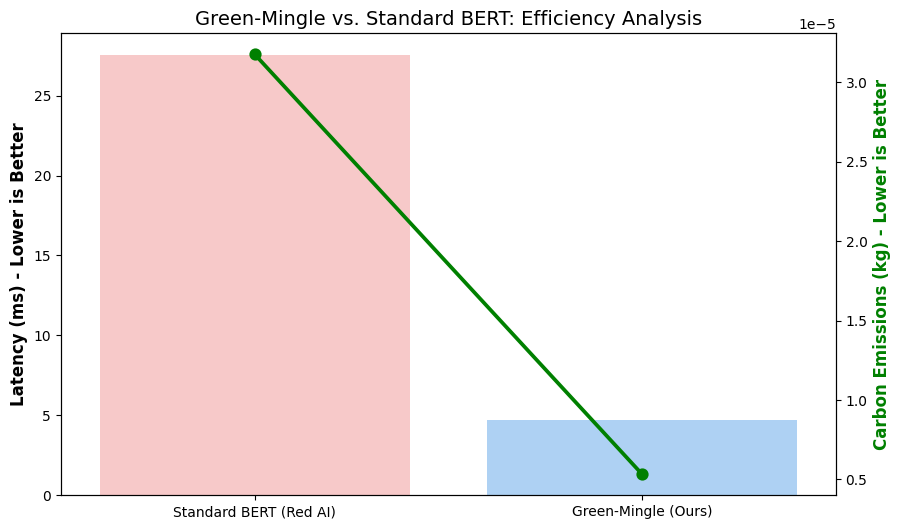

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Latency (Bars)
colors = ['#ff9999', '#66b3ff'] # Red for Baseline, Blue for Yours
sns.barplot(x='Model', y='Avg Latency (ms)', data=results_df, palette=colors, ax=ax1, alpha=0.6)
ax1.set_ylabel('Latency (ms) - Lower is Better', fontsize=12, fontweight='bold')
ax1.set_xlabel('')

# Plot Energy (Lines/Dots) on a secondary axis
ax2 = ax1.twinx()
sns.pointplot(x='Model', y='CO2 Emissions (kg)', data=results_df, color='green', markers='o', ax=ax2)
ax2.set_ylabel('Carbon Emissions (kg) - Lower is Better', color='green', fontsize=12, fontweight='bold')

plt.title('Green-Mingle vs. Standard BERT: Efficiency Analysis', fontsize=14)
plt.show()